#### Data Description: The dataset has future merchant transaction activity, up to 1 year for each merchant, for merchants that start over a 1 year period (2015-2016). Although the data is made up, you can consider this to be a random sample of future merchants. Each observation is a transaction amount. The dataset contains each of these merchants’ 1st year of life, so it contains their 1st charge through all charges up until 365 days later. If the merchant stops processing transactions, then they would no longer appear. 

### How would you propose segmenting these users in ways that can be useful for Sales, Product, and other teams?

#### Initially I investigated first few merchants. I saw that variability in number of days of data was high, with potential gaps. Sale variability was also high, with significant outliers. Therefore I cleaned the data, removing days with 2 sigma outliers. 
#### With the remaining data I report on statistics like the maximum sales, minimum sales, mean sales, the variance in the number of sales, and the number of days where transactions took place (as well as all possible days in the range). This data can be used to segment companies into categories like long term and short term customers, high vs low number of transactions, high vs low mean sales, and stability, among others.
### Actionable Insight: The vast majority of merchants use the service for fewer than 10 days and have fewer than 50 transactions. Most users also have average transactions of a few hundred dollars and a maximum transaction of a few thousand dollars. Since the smaller transaction users dominate, and most users do not use the service long, some Sales segments should focus on retaining users longer, and other segments should focus on maximizing the number of users who have the largest average transactions.

### In particular, how would you identify and predict high growth merchants?

#### In order to evaluate trends in the sales over time, first I need to clean the data again. Daily (or in some cases hourly!) fluctuations are too noisy and can lead to overtrained models. Therefore I downsample the data so that I have weekly datapoints instead. 
#### By investigating the first few merchants, I see that the simplest method of measuring growth (fitting a line) could be dangerous. For example, the first company has a generally upward trend. However the profit trend in the most recent months is predominately downward. Instead I use a second order spline to make predictions about the current trends for the merchant. This spline does a better job of picking up on the more recent trends that will be more indicative of a merchants current value. 
### Actionable Insight: Using a second order spline, get an even distribution of merchants that are projected to perform well and merchants that are projected to perform poorly for data with sufficient data points. 

#### Note: Since many of the datasets have too few data points to be fitted with the spline, get a peak at zero (where the linear interpolation returns the previous value of the data point). Additional analysis of these poorly performing fits should be done, but is outside the scope of this challenge.

In [1]:
import numpy
import seaborn as sns
import pandas as pd
import matplotlib
from matplotlib import *
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import pandas.tseries.holiday as holis
from pandas.tseries.holiday import *

In [3]:
holidays = holis.USFederalHolidayCalendar().holidays(start='2002-01-01', end='2015-12-31')

In [4]:
merch_trans = pd.read_csv('data/case_final.csv',parse_dates=[0,1],index_col=1)

#### Use pandas to identify holidays and then remove holiday dates from the dataset. These days can be unpredictable for a variety of different reasons, and incorporating them into the model is outside of the scope of this challenge

In [5]:
h_bool = merch_trans.index.map(lambda x: 1 if x.date() in holidays else 0)

In [6]:
first_user = merch_trans[(merch_trans['user']=='00038f0484334ac047449166cfbbf6452b31c85c') & (h_bool==0)]

In [7]:
first_user.head()

,user,amount_in_cents
time,,
2016-02-19 23:39:56.925000,00038f0484334ac047449166cfbbf6452b31c85c,1203
2016-02-19 23:41:47.026000,00038f0484334ac047449166cfbbf6452b31c85c,1203
2016-02-23 15:19:54.836000,00038f0484334ac047449166cfbbf6452b31c85c,2405
2016-02-23 15:21:08.273000,00038f0484334ac047449166cfbbf6452b31c85c,2405
2016-02-24 15:19:39.386000,00038f0484334ac047449166cfbbf6452b31c85c,1203


#### Select and examine data from the first user in the list. My initial impression of the data is that it varies rapidly (a lot of datapoints), which will cause problems for a model, and has visible outliers

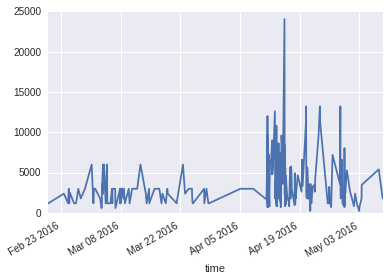

In [8]:
first_user.amount_in_cents.plot(grid=True)

In [9]:
print len(first_user)

310


In [10]:
first_stats = first_user.describe(percentiles=[0.0005,.025,.16,.84,.975,.9995])

#### Use pandas describe() method to get information about the underlying statistics of the dataset

In [11]:
first_stats

,amount_in_cents
count,310.000000
mean,3159.106452
std,2734.172656
min,241.000000
0.1%,241.000000
2.5%,722.000000
16%,1203.000000
50%,2405.000000
84%,5358.760000
97.5%,11491.000000


#### Use numpy to efficiently select the values of the 97.5 and 2.5% quantiles. I then use these values to exclude 2 sigma outliers from the sample

In [12]:
h_2sig = numpy.percentile(first_user.amount_in_cents,97.5)
l_2sig = numpy.percentile(first_user.amount_in_cents,2.5)

In [13]:
print h_2sig,l_2sig

11491.0 722.0


In [14]:
len(first_user[first_user.amount_in_cents>h_2sig]),len(first_user[first_user.amount_in_cents<l_2sig])

(8, 5)

In [15]:
first_user = first_user[(first_user.amount_in_cents<=h_2sig) & (first_user.amount_in_cents>=l_2sig)]

In [16]:
print len(first_user)

297


#### After removing outliers dataset has a much more reasonable range of values, but still too many datapoints

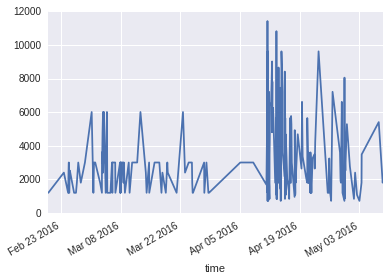

In [17]:
first_user.amount_in_cents.plot(grid=True)

In [18]:
first_stats = first_user.describe(percentiles=[0.0005,.025,.16,.84,.975,.9995])

In [19]:
first_stats

,amount_in_cents
count,297.000000
mean,2913.925926
std,2014.443068
min,722.000000
0.1%,722.000000
2.5%,842.000000
16%,1203.000000
50%,2405.000000
84%,4766.800000
97.5%,8562.600000


#### Resample the data by week in order to get a manageable amount of information for fitting 

In [20]:
u1_frame = pd.DataFrame()
u1_frame['weekly'] = first_user.amount_in_cents.resample('W')

In [21]:
u1_frame

,weekly
time,
2016-02-21,1203.000000
2016-02-28,2037.125000
2016-03-06,2696.419355
2016-03-13,2500.473684
2016-03-20,2029.750000
2016-03-27,2313.000000
2016-04-03,1804.333333
2016-04-10,3007.000000
2016-04-17,3407.731343


#### Add a date one week after the last data point in the set, then use a second order spline to interpolate the future transaction value for the merchant during that week

In [22]:
from datetime import timedelta
proj_week = u1_frame.index[-1]+timedelta(days=7)
proj_frame = pd.DataFrame([numpy.nan],columns=['weekly'],index=[proj_week])
u1_frame = u1_frame.append(proj_frame)

In [23]:
u1_frame = u1_frame.apply(pd.Series.interpolate,method='spline',order=2)

In [24]:
u1_frame

,weekly
2016-02-21,1203.000000
2016-02-28,2037.125000
2016-03-06,2696.419355
2016-03-13,2500.473684
2016-03-20,2029.750000
2016-03-27,2313.000000
2016-04-03,1804.333333
2016-04-10,3007.000000
2016-04-17,3407.731343
2016-04-24,2997.666667


In [25]:
u1_frame = u1_frame.apply(lambda x: x / numpy.max(x))

#### See that data after downsampling to weekly datapoints is smoother and easier to interpret. Behavior of spline seems reasonable and intuitive

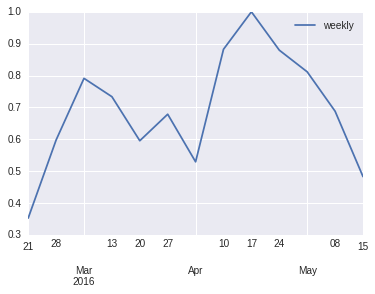

In [26]:
u1_frame.plot(grid=True)

#### Add information about the projected performance of the merchant (proj_diff) and the total duration of transactions (tot_days) to the pandas statistics. This information will be saved to be examined in aggregate for all merchants, with the merchant id as the column name. 

In [27]:
first_stats=first_user.describe()
proj_diff = u1_frame.weekly[-1]-u1_frame.weekly[-2]
tot_diff = first_user.index[-1]-first_user.index[0]
tot_days = tot_diff.days

In [28]:
print proj_diff

-0.205020429048


In [29]:
day_frame = pd.DataFrame([tot_days],columns=['amount_in_cents'],index=['days'])
proj_frame = pd.DataFrame([proj_diff],columns=['amount_in_cents'],index=['projection'])
first_stats = first_stats.append(day_frame)
first_stats = first_stats.append(proj_frame)

In [30]:
first_stats

,amount_in_cents
count,297.000000
mean,2913.925926
std,2014.443068
min,722.000000
25%,1203.000000
50%,2405.000000
75%,3488.000000
max,11425.000000
days,78.000000
projection,-0.205020


In [31]:
first_stats.columns = ['00038f0484334ac047449166cfbbf6452b31c85c']

In [32]:
first_stats

,00038f0484334ac047449166cfbbf6452b31c85c
count,297.000000
mean,2913.925926
std,2014.443068
min,722.000000
25%,1203.000000
50%,2405.000000
75%,3488.000000
max,11425.000000
days,78.000000
projection,-0.205020


#### Store all the unique merchant IDs. See that there are 8402 unique merchants

In [33]:
users = merch_trans.user.unique()

In [34]:
print users,len(users)

['00038f0484334ac047449166cfbbf6452b31c85c'
 '0012a74e2bb1ab0073b2e18532e87474b6b7cfca'
 '001855810c25d8bb03210f8c0114de27da9cd76c' ...,
 'ffe4880511ffadf79ec49d7ee03ce445f8f1bd7e'
 'ffe54ded2eb34c35ed8e74e8a2961d30e4b1515e'
 'ffe986bb5a18d164ed9b1cc4e1c07016d396a2c2'] 8402


#### Investigate the second user. Because of the sparsity of data for this user (only two datapoints), removing outliers is not possible. Also a second order spline cannot be used. Instead a linear interpolation is used. For the generalized algorithm, datasets without at least 4 datapoints (approximately a month) will be treated like the second 'short' user, and a flag will be added to indicate that there was not enough data for a proper projection.

In [35]:
short_user = merch_trans[(merch_trans['user']=='0012a74e2bb1ab0073b2e18532e87474b6b7cfca') & (h_bool==0)]

In [36]:
short_stats = short_user.describe(percentiles=[0.0005,.025,.16,.84,.975,.9995])

In [37]:
short_stats

,amount_in_cents
count,2.000000
mean,4570.000000
std,1871.004543
min,3247.000000
0.1%,3248.323000
2.5%,3313.150000
16%,3670.360000
50%,4570.000000
84%,5469.640000
97.5%,5826.850000


In [38]:
short_user

,user,amount_in_cents
time,,
2016-11-04 14:50:09.257000,0012a74e2bb1ab0073b2e18532e87474b6b7cfca,5893
2016-11-10 00:19:25.407000,0012a74e2bb1ab0073b2e18532e87474b6b7cfca,3247


In [39]:
h_2sig = numpy.percentile(short_user.amount_in_cents,97.5)
l_2sig = numpy.percentile(short_user.amount_in_cents,2.5)

In [40]:
len(short_user[short_user.amount_in_cents>h_2sig]),len(short_user[short_user.amount_in_cents<l_2sig])

(1, 1)

In [41]:
short_user = short_user[(short_user.amount_in_cents<=h_2sig) & (short_user.amount_in_cents>=l_2sig)]

#### If outliers are removed, then the short user dataset has no entries. Therefore I choose to keep the outliers.

In [42]:
print len(short_user)

0


In [43]:
short_user = merch_trans[(merch_trans['user']=='0012a74e2bb1ab0073b2e18532e87474b6b7cfca') & (h_bool==0)]

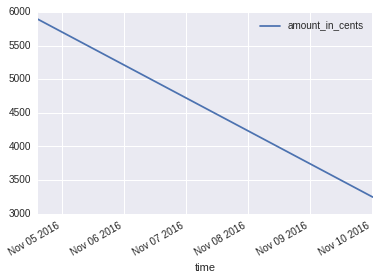

In [44]:
short_user.plot(grid=True)

In [45]:
short_frame = pd.DataFrame()
short_frame['weekly'] = short_user.amount_in_cents.resample('W')

In [46]:
proj_week = short_frame.index[-1]+timedelta(days=7)
proj_frame = pd.DataFrame([numpy.nan],columns=['weekly'],index=[proj_week])
short_frame = short_frame.append(proj_frame)

In [47]:
print short_frame

            weekly
2016-11-06    5893
2016-11-13    3247
2016-11-20     NaN


#### Since there are only two datapoints, only linear interpolation is possible. For this reason, if the spline fails, I will choose to use a simple linear interpolation (but it will likely just return the same value as the last week in the dataset, and therefore give the projected change as zero)

In [48]:
short_frame = short_frame.apply(pd.Series.interpolate)

In [49]:
print short_frame

            weekly
2016-11-06    5893
2016-11-13    3247
2016-11-20    3247


In [50]:
short_frame = short_frame.apply(lambda x: x / numpy.max(x))

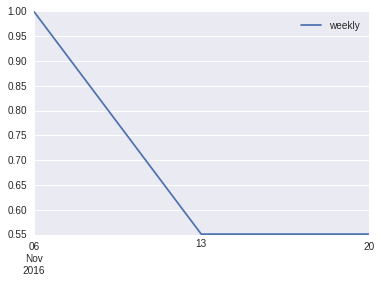

In [51]:
short_frame.plot(grid=True)

#### The second user with sufficient data for interpolation is similar to the first user. Therefore I apply the same methods and see that the behavior for this dataset is also reasonable. Now I can use what I have learned so far to make a generalized algorithm to analyze the merchants.

In [52]:
second_user = merch_trans[(merch_trans['user']=='001855810c25d8bb03210f8c0114de27da9cd76c') & (h_bool==0)]

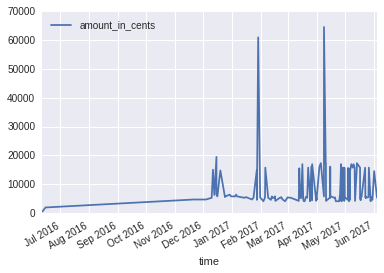

In [53]:
second_user.plot(grid=True)

In [54]:
second_stats = second_user.describe(percentiles=[0.0005,.025,.16,.84,.975,.9995])

In [55]:
second_stats

,amount_in_cents
count,195.000000
mean,7725.482051
std,7048.730423
min,481.000000
0.1%,620.971000
2.5%,4089.000000
16%,4690.000000
50%,5412.000000
84%,15028.160000
97.5%,17011.000000


In [56]:
h_2sig = numpy.percentile(second_user.amount_in_cents,97.5)
l_2sig = numpy.percentile(second_user.amount_in_cents,2.5)

In [57]:
second_user = second_user[(second_user.amount_in_cents<=h_2sig) & (second_user.amount_in_cents>=l_2sig)]

#### Second user after removing outliers

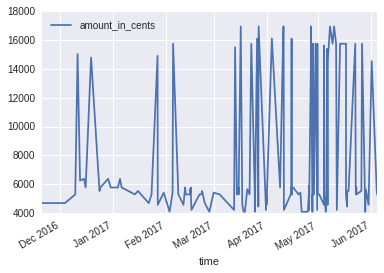

In [58]:
second_user.plot(grid=True)

In [59]:
u2_frame = pd.DataFrame()
u2_frame['weekly'] = second_user.amount_in_cents.resample('W')

In [60]:
print u2_frame

                  weekly
time                    
2016-11-20   4690.000000
2016-11-27           NaN
2016-12-04   4690.000000
2016-12-11  10162.000000
2016-12-18   6133.333333
2016-12-25   8698.666667
2017-01-01   5922.500000
2017-01-08   5972.666667
2017-01-15   5371.333333
2017-01-22   4690.000000
2017-01-29   8257.666667
2017-02-05   7666.750000
2017-02-12   5231.000000
2017-02-19   5315.300000
2017-02-26   4978.600000
2017-03-05   5351.500000
2017-03-12   4209.000000
2017-03-19   6206.347826
2017-03-26   8057.285714
2017-04-02   7095.400000
2017-04-09  10943.500000
2017-04-16   6706.615385
2017-04-23   4930.666667
2017-04-30   8996.875000
2017-05-07   8428.083333
2017-05-14  14230.833333
2017-05-21   7311.800000
2017-05-28   6179.230769
2017-06-04   7143.200000


In [61]:
proj_week = u2_frame.index[-1]+timedelta(days=7)
proj_frame = pd.DataFrame([numpy.nan],columns=['weekly'],index=[proj_week])
u2_frame = u2_frame.append(proj_frame)
u2_frame = u2_frame.apply(pd.Series.interpolate,method='spline',order=2)

In [62]:
print u2_frame

                  weekly
2016-11-20   4690.000000
2016-11-27   1985.485089
2016-12-04   4690.000000
2016-12-11  10162.000000
2016-12-18   6133.333333
2016-12-25   8698.666667
2017-01-01   5922.500000
2017-01-08   5972.666667
2017-01-15   5371.333333
2017-01-22   4690.000000
2017-01-29   8257.666667
2017-02-05   7666.750000
2017-02-12   5231.000000
2017-02-19   5315.300000
2017-02-26   4978.600000
2017-03-05   5351.500000
2017-03-12   4209.000000
2017-03-19   6206.347826
2017-03-26   8057.285714
2017-04-02   7095.400000
2017-04-09  10943.500000
2017-04-16   6706.615385
2017-04-23   4930.666667
2017-04-30   8996.875000
2017-05-07   8428.083333
2017-05-14  14230.833333
2017-05-21   7311.800000
2017-05-28   6179.230769
2017-06-04   7143.200000
2017-06-11   8923.972559


#### Normalize the result

In [63]:
u2_frame = u2_frame.apply(lambda x: x / numpy.max(x))

In [64]:
second_stats = second_user.describe()

In [65]:
proj_diff = u2_frame.weekly[-1]-u2_frame.weekly[-2]
tot_diff = second_user.index[-1]-second_user.index[0]
tot_days = tot_diff.days

In [66]:
day_frame = pd.DataFrame([tot_days],columns=['amount_in_cents'],index=['days'])
proj_frame = pd.DataFrame([proj_diff],columns=['amount_in_cents'],index=['projection'])
second_stats = second_stats.append(day_frame)
second_stats = second_stats.append(proj_frame)
stats = second_stats.index.unique()

In [67]:
second_stats.columns = ['001855810c25d8bb03210f8c0114de27da9cd76c']

In [68]:
second_stats

,001855810c25d8bb03210f8c0114de27da9cd76c
count,188.000000
mean,7044.659574
std,4055.558771
min,4089.000000
25%,5291.000000
50%,5412.000000
75%,5772.000000
max,16957.000000
days,196.000000
projection,0.125135


#### Show how combining two merchant IDs with all of their information will look

In [69]:
stat_list = []
stat_list.append(first_stats.transpose())
stat_list.append(second_stats.transpose())
test_comb = pd.concat(stat_list)

In [70]:
print test_comb

                                          count         mean          std  \
00038f0484334ac047449166cfbbf6452b31c85c    297  2913.925926  2014.443068   
001855810c25d8bb03210f8c0114de27da9cd76c    188  7044.659574  4055.558771   

                                           min   25%   50%   75%    max  days  \
00038f0484334ac047449166cfbbf6452b31c85c   722  1203  2405  3488  11425    78   
001855810c25d8bb03210f8c0114de27da9cd76c  4089  5291  5412  5772  16957   196   

                                          projection  
00038f0484334ac047449166cfbbf6452b31c85c   -0.205020  
001855810c25d8bb03210f8c0114de27da9cd76c    0.125135  


#### Second user after downsampling to weekly datapoints

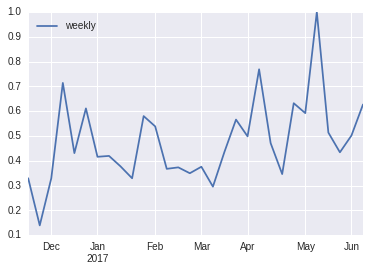

In [71]:
u2_frame.plot(grid=True)

#### Iterate over all merchant IDs to get all the statistics for all the datasets

In [106]:
def get_merchant_stats(merch_data):
    stat_list = []
    users = merch_data.user.unique()
    hdays = holis.USFederalHolidayCalendar().holidays(start='2002-01-01', end='2015-12-31')
    h_bool = merch_data.index.map(lambda x: 1 if x.date() in hdays else 0)
    count=0
    for u_id in users:
        if(count%1000==0):
            print len(users),u_id
        count+=1
        cur_user = merch_data[(merch_data['user']==u_id) & (h_bool==0)]
        if(len(cur_user)==0):
            continue
        h_2sig = numpy.percentile(cur_user.amount_in_cents,97.5)
        l_2sig = numpy.percentile(cur_user.amount_in_cents,2.5)
        cur_user = cur_user[(cur_user.amount_in_cents<=h_2sig) & (cur_user.amount_in_cents>=l_2sig)]
        cur_stats = cur_user.describe()

        if(len(cur_user)>0):
            week_frame = pd.DataFrame()
            week_frame['weekly'] = cur_user.amount_in_cents.resample('W')
            if(len(week_frame)>0):
                proj_week = week_frame.index[-1]+timedelta(days=7)
                proj_frame = pd.DataFrame([numpy.nan],columns=['weekly'],index=[proj_week])
                week_frame = week_frame.append(proj_frame)
                try:
                    week_frame = week_frame.apply(pd.Series.interpolate,method='spline',order=2)
                except:
                    week_frame = week_frame.apply(pd.Series.interpolate)
                week_frame = week_frame.apply(lambda x: x / numpy.max(x))
                
                proj_diff = week_frame.weekly[-1]-week_frame.weekly[-2]
                tot_diff = cur_user.index[-1]-cur_user.index[0]
                tot_days = tot_diff.days
            
                day_frame = pd.DataFrame([tot_days],columns=['amount_in_cents'],index=['days'])
                proj_frame = pd.DataFrame([proj_diff],columns=['amount_in_cents'],index=['projection'])
                cur_stats = cur_stats.append(day_frame)
                cur_stats = cur_stats.append(proj_frame)
                cur_stats.columns=[u_id]
                stat_list.append(cur_stats.transpose())
            else:
                tot_diff = cur_user.index[-1]-cur_user.index[0]
                tot_days = tot_diff.days
                day_frame = pd.DataFrame([tot_days],columns=['amount_in_cents'],index=['days'])
                proj_frame = pd.DataFrame([numpy.nan],columns=['amount_in_cents'],index=['projection'])
                cur_stats = cur_stats.append(day_frame)
                cur_stats = cur_stats.append(proj_frame)
                cur_stats.columns=[u_id]
                stat_list.append(cur_stats.transpose())   
        else:
            cur_user = merch_data[(merch_data['user']==u_id) & (h_bool==0)]
            cur_stats = cur_user.describe()
            tot_diff = cur_user.index[-1]-cur_user.index[0]
            tot_days = tot_diff.days
            day_frame = pd.DataFrame([tot_days],columns=['amount_in_cents'],index=['days'])
            proj_frame = pd.DataFrame([numpy.nan],columns=['amount_in_cents'],index=['projection'])
            cur_stats = cur_stats.append(day_frame)
            cur_stats = cur_stats.append(proj_frame)
            cur_stats.columns=[u_id]
            stat_list.append(cur_stats.transpose())            
    out_frame = pd.concat(stat_list)
    return out_frame

#### Running this on ~8500 merchants takes a while (about 30 minutes). If I had more time I would try to optimize the processing more.

In [107]:
stat_frame = get_merchant_stats(merch_trans)

8402 00038f0484334ac047449166cfbbf6452b31c85c
8402 1e40d3b9f40d7f3194ae3626c22f7ac5b5e2cf85
8402 3c4874e5240a1c0f57cb83d0a034ffe5d0402090
8402 5c22a1f9b95b277326ec16fc29b39a3758665fbe
8402 7bb37e7a5ec56942137227e85ab2cfd9cee77247
8402 9a1721579a05b7258916feb12fe30a1e0ab83cac
8402 b9910d50a2ce7ec1647b33f9d6a227a3ec569a3a
8402 d61aaf95a3af92cbf4d6ed1ac2558e008b510ec8
8402 f34c25f0467dd24ca059a8bfe29f08760bedccba


#### Since I excluded users with no non-holiday datapoints I have slightly fewer than 8402 users in the end

In [109]:
len(stat_frame)

8394

#### Vast majority of merchants have a transaction maximum below $1000

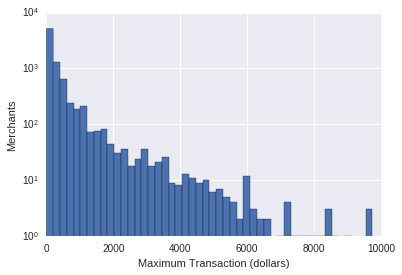

In [141]:
ax = (stat_frame['max']/100).hist(bins=200,log=True)
ax.set_xlim(0,10000)
ax.set_xlabel('Maximum Transaction (dollars)')
ax.set_ylabel('Merchants')

#### Vast majority of merchants have minimum transactions below $100

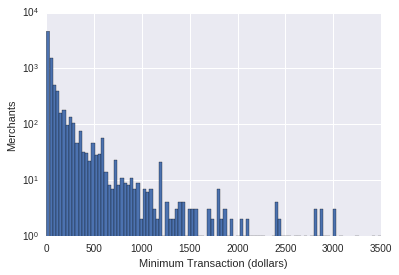

In [134]:
ax = (stat_frame['min']/100).hist(bins=500,log=True)
ax.set_xlim(0,3500)
ax.set_xlabel('Minimum Transaction (dollars)')
ax.set_ylabel('Merchants')

#### Vast majority of companies have low (<$100) standard deviation

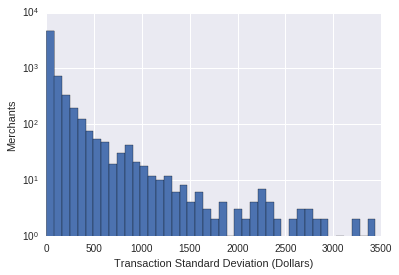

In [147]:
ax = (stat_frame['std']/100).hist(bins=300,log=True)
ax.set_xlim(0,3500)
ax.set_xlabel('Transaction Standard Deviation (Dollars)')
ax.set_ylabel('Merchants')

#### On average merchants tend to have transactions that are worth only a few hundred dollars.

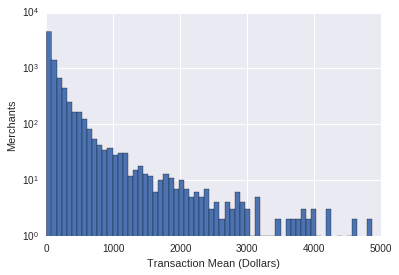

In [171]:
ax = (stat_frame['mean']/100).hist(bins=300,log=True)
ax.set_xlim(0,5000)
ax.set_xlabel('Transaction Mean (Dollars)')
ax.set_ylabel('Merchants')

#### See that a large number of companies do not even have a months worth of transactions! Should focus on these companies to determine why they have so few

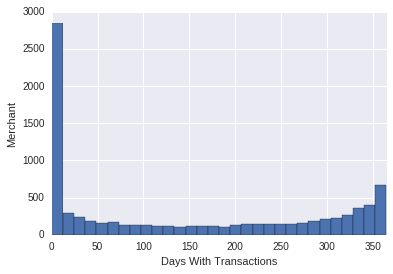

In [157]:
ax = stat_frame['days'].hist(bins=30)
ax.set_xlim(0,365)
ax.set_xlabel('Days With Transactions')
ax.set_ylabel('Merchant')

#### Also see that the majority of companies have fewer than 50 transactions. This is another good category to focus on

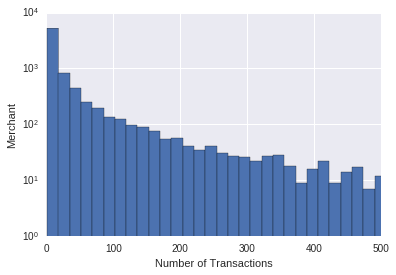

In [169]:
ax = stat_frame['count'].hist(bins=5000,log=True)
ax.set_xlim(0,500)
ax.set_xlabel('Number of Transactions')
ax.set_ylabel('Merchant')

In [172]:
proj_frame = stat_frame['projection'].dropna()

#### The projection seems to do a pretty good job of evenly splitting the data into good performing merchants and poorly performing merchants. The peak at zero likely comes from datasets where there were insufficient datapoints for interpolation (and therefore the linear interpolation was used instead of the spline)

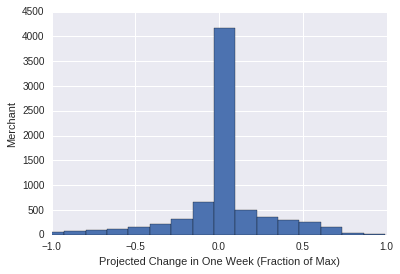

In [177]:
ax = proj_frame.hist(bins=100)
ax.set_xlim(-1,1)
ax.set_xlabel('Projected Change in One Week (Fraction of Max)')
ax.set_ylabel('Merchant')